In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.spatial.distance import hamming
os.chdir('..')
import functions.helperfunctions as hf
import functions.myfunctions as mf
# from functions.IPAfunctions import _calculate_weights
from PairingVDJdb_MI import _define_individuals
pd.options.mode.chained_assignment = None

In [2]:
estimatedMI = pd.read_csv('data/output/mutual_info/estimated_mutual_info_all_epitopes.csv')
estimatedMI.columns = ['name', 'real', 'shuffle']

estimatedMI[['epitope', 'vars']] = estimatedMI['name'].str.split('_', 1, expand=True)
estimatedMI[['var1','var2']] = estimatedMI['vars'].str.split('-', 1, expand=True)
estimatedMI = estimatedMI.drop(['name','vars'], axis=1)
estimatedMI['real_MI'] = estimatedMI['real'] - estimatedMI['shuffle']
estimatedMI['var1'] = estimatedMI['var1'].replace('cdr3a','CDR3a')
estimatedMI['var2'] = estimatedMI['var2'].replace('cdr3a','CDR3a')
estimatedMI['var1'] = estimatedMI['var1'].replace('cdr3b','CDR3b')
estimatedMI['var2'] = estimatedMI['var2'].replace('cdr3b','CDR3b')
print(estimatedMI)

          real    shuffle     epitope   var1   var2   real_MI
0    15.874756   7.251155   ASNENMETM     Ja  CDR3a  8.623601
1     8.277162   5.880050   ASNENMETM     Ja  CDR3b  2.397112
2     0.816246   0.603484   ASNENMETM     Ja     Jb  0.212762
3     3.891015   2.705514   ASNENMETM     Jb  CDR3a  1.185500
4     9.995252   2.261418   ASNENMETM     Jb  CDR3b  7.733834
..         ...        ...         ...    ...    ...       ...
355   5.359227   4.437795  background     Vb  CDR3a  0.921433
356   7.316673   4.229559  background     Vb  CDR3b  3.087115
357   1.086636   0.884852  background     Vb     Ja  0.201785
358   0.475710   0.346679  background     Vb     Jb  0.129030
359  22.666520  19.730775  background  CDR3a  CDR3b  2.935746

[360 rows x 6 columns]


/tmp/ipykernel_480294/3498085612.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  estimatedMI[['epitope', 'vars']] = estimatedMI['name'].str.split('_', 1, expand=True)
/tmp/ipykernel_480294/3498085612.py:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  estimatedMI[['var1','var2']] = estimatedMI['vars'].str.split('-', 1, expand=True)


In [3]:
cdr3abMI = estimatedMI.loc[estimatedMI['var1'].isin(['CDR3a','CDR3b'])]
cdr3abMI = cdr3abMI.loc[cdr3abMI['var1'].isin(['CDR3a','CDR3b'])]
print(cdr3abMI)

          real    shuffle           epitope   var1   var2    real_MI
14   42.514086  28.393550         ASNENMETM  CDR3a  CDR3b  14.120535
29   62.903822  42.657593         ATDALMTGF  CDR3a  CDR3b  20.246229
44   30.203834  29.848713        AVFDRKSDAK  CDR3a  CDR3b   0.355122
59   56.597613  50.543606         CINGVCWTV  CDR3a  CDR3b   6.054008
74   35.442074  34.560753        ELAGIGILTV  CDR3a  CDR3b   0.881321
89   27.019347  19.341233         GILGFVFTL  CDR3a  CDR3b   7.678114
104  49.200411  32.111785         GLCTLVAML  CDR3a  CDR3b  17.088626
119  39.556004  25.412804         HGIRNASFI  CDR3a  CDR3b  14.143200
134  34.412055  33.190943         IVTDFSVIK  CDR3a  CDR3b   1.221112
149  73.484959  57.066165         KSKRTPMGF  CDR3a  CDR3b  16.418794
164  34.993663  29.623187         LLWNGPMAV  CDR3a  CDR3b   5.370476
179  33.868407  30.642950         LSLRNPILV  CDR3a  CDR3b   3.225457
194  64.072052  57.032108         LTDEMIAQY  CDR3a  CDR3b   7.039944
209  50.498113  42.937499         

In [4]:
ff1 = 'data/output/pairing_GAMI/all_eps_L06/'
ff11 = 'data/output/pairing_GAMI/big_eps_700_L06/'
ff2 = 'data/output/pairing_GA/all_eps/'
ff22 = 'data/output/pairing_GA/big_eps_700/'
ff3 = 'data/output/pairing_MI-IPA/all_eps_noconf/'
ff33 = 'data/output/pairing_MI-IPA/big_eps_noconf_700/'

save_folder1 = 'figures'

In [5]:
vdj = pd.read_csv('data/vdj_cleaned_subset_for_MI.csv', index_col=0).drop('Unnamed: 0', axis=1)
vdj = vdj.replace('https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#', '10xGenomics')
vdj = vdj.replace('https://github.com/antigenomics/vdjdb-db/issues/*', 'GitHubIssue', regex=True)
vdj = vdj.loc[vdj['Epitope'] != 'KLGGALQAK'] # because too big - takes forever
epitopes = vdj['Epitope'].unique().tolist()
epcounts = vdj['Epitope'].value_counts()
epitopes_small = epcounts.loc[epcounts<1000].index.values
# vdj = vdj.loc[vdj['Epitope'].isin(epitopes)]

In [6]:
def _calculate_weights_oneChain(A, weights):
    assert (weights in ['yes', None, 'no']) | (type(weights) == float), 'weights should be one of [yes, None, no] or a float'
    if weights == 'no':
        weights = None

    if isinstance(weights, float):
        X = A.copy()
        assert X.shape == (A.shape[0], A.shape[1])
        seqs = [''.join(row) for row in X]
        
        weights = [1/sum([int(hamming(list(x), list(y)) <= weights) for y in seqs]) for x in seqs]
        print('effective set size: ', sum(weights))
        weights = np.array(weights)
    
    return(sum(weights))

In [7]:
mode_results = pd.DataFrame()

for ff in sorted(os.listdir(ff1)):
    if ('vgene-no' in ff) & ('confidence-none' in ff):
         print(ff)
         filename = ff1+ff
      #    print(df)

         f1 = ff.replace('small_ind', 'smallInd')
         f1 = f1.replace('prop_test', 'propTest')
         f1 = f1.replace('GA_repeats', 'GArepeats')
         f1 = f1.replace('MI_repeats', 'MIrepeats')
         f1 = f1.replace('distance_type', 'disttype')
         properties = {x.split('-')[0]:x.split('-')[1] for x in f1.split('_') if '.csv' not in x}
         if properties['epitope'] in epitopes:
            epdf = _define_individuals(vdj, properties['epitope'], 'no')
            epdf = mf.prepare_data(epdf, col1='cdr3a_IMGTgaps', col2 ='cdr3b_IMGTgaps')
            df = hf.load_df(filename, epdf.shape[0])
            a = np.array(epdf['cdr3a_IMGTgaps_padded'].str.split(', ', expand=True))
            a = a[:, ~np.all(a[1:] == a[:-1], axis=0)] # remove columns where all values are equal to first value
            epdf['alpha'] = [''.join(x) for x in a] # then substitute original column
            b = np.array(epdf['cdr3b_IMGTgaps_padded'].str.split(', ', expand=True))
            b = b[:, ~np.all(b[1:] == b[:-1], axis=0)] # remove columns where all values are equal to first value
            epdf['beta'] = [''.join(x) for x in b] # then substitute original column   

            Na = _calculate_weights_oneChain(a, 0.6) 
            Nb = _calculate_weights_oneChain(b, 0.6)  
                
            for w in range(100):
               df_final = hf.check_mode_correct_IPA(df.reset_index(),epdf)
               df_mode = df_final[['mode_freq','correct']]
               df_mode['L'] = properties['L']
               df_mode['epitope'] = properties['epitope']
               df_mode['largest_id'] = epdf['subject-PMID'].value_counts().max()
               df_mode['Na'] = Na
               df_mode['Nb'] = Nb
               df_mode['mode_iter'] = w
               mode_results = pd.concat([mode_results,df_mode])

epitope-ASNENMETM_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_GAthresh-0.95_repairing-True_kNN-_distance_type-_GA_repeats-100_MI_repeats-10.csv.gz
Using individuals as provided
[34]
(2010, 11)
[34]
elapsed: 1.3637096881866455
effective set size:  1.5719040244928595
effective set size:  1.4640153228439832
epitope-ATDALMTGF_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_GAthresh-0.95_repairing-True_kNN-_distance_type-_GA_repeats-100_MI_repeats-10.csv.gz
Using individuals as provided
[21]
(1250, 11)
[21]
elapsed: 3.731525182723999
effective set size:  3.8989141663315916
effective set size:  1.875651477808608
epitope-CINGVCWTV_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_GAthresh-0.95_repairing-True_kNN-_distance_type-_GA_repeats-100_MI_repeats-10.csv.gz
Using 

In [8]:
for ff110 in sorted(os.listdir(ff11)):
    if '.txt' not in ff110:
      for ff in os.listdir(ff11+ff110):
         if ('.csv' in ff) & ('vgene-no' in ff)  & ('KLGGALQAK' not in ff):
            print(ff)
            filename = ff11+ff110+'/'+ff
         #    print(df)

            f1 = ff.replace('small_ind', 'smallInd')
            f1 = f1.replace('prop_test', 'propTest')
            f1 = f1.replace('GA_repeats', 'GArepeats')
            f1 = f1.replace('MI_repeats', 'MIrepeats')
            f1 = f1.replace('distance_type', 'disttype')
            properties = {x.split('-')[0]:x.split('-')[1] for x in f1.split('_') if '.csv' not in x}
            if properties['epitope'] in epitopes:
               df1 = pd.read_csv('data/big_epitopes_subsamples_700/' + properties['epitope'] + '_ss' + ff110 + '.csv')
               epdf = _define_individuals(df1, properties['epitope'], 'no')
               epdf = mf.prepare_data(epdf, col1='cdr3a_IMGTgaps', col2 ='cdr3b_IMGTgaps')
               df = hf.load_df(filename, epdf.shape[0])
               a = np.array(epdf['cdr3a_IMGTgaps_padded'].str.split(', ', expand=True))
               a = a[:, ~np.all(a[1:] == a[:-1], axis=0)] # remove columns where all values are equal to first value
               epdf['alpha'] = [''.join(x) for x in a] # then substitute original column
               b = np.array(epdf['cdr3b_IMGTgaps_padded'].str.split(', ', expand=True))
               b = b[:, ~np.all(b[1:] == b[:-1], axis=0)] # remove columns where all values are equal to first value
               epdf['beta'] = [''.join(x) for x in b] # then substitute original column   

               Na = _calculate_weights_oneChain(a, 0.6) 
               Nb = _calculate_weights_oneChain(b, 0.6)      
               
               for w in range(100):
                  df_final = hf.check_mode_correct_IPA(df.reset_index(),epdf)
                  df_mode = df_final[['mode_freq','correct']]
                  df_mode['L'] = properties['L']
                  df_mode['epitope'] = properties['epitope']+'_'+ff110
                  df_mode['largest_id'] = epdf['subject-PMID'].value_counts().max()
                  df_mode['Na'] = Na
                  df_mode['Nb'] = Nb
                  df_mode['mode_iter'] = w
                  mode_results = pd.concat([mode_results,df_mode])

epitope-RAKFKQLL_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_GAthresh-0.95_repairing-True_kNN-_distance_type-_GA_repeats-100_MI_repeats-10.csv.gz
Using individuals as provided
[117]
(7000, 11)
[117]
elapsed: 467.139689207077
effective set size:  2.300386123515962
effective set size:  2.2435006954114938
epitope-GILGFVFTL_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_GAthresh-0.95_repairing-True_kNN-_distance_type-_GA_repeats-100_MI_repeats-10.csv.gz
Using individuals as provided
[117]
(7000, 11)
[117]
elapsed: 161.52877855300903
effective set size:  2.9430139092525107
effective set size:  2.3587534421165715
epitope-AVFDRKSDAK_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_GAthresh-0.95_repairing-True_kNN-_distance_type-_GA_repeats-100_MI_repeats-10.csv.gz
Usi

In [9]:
assert len(mode_results['epitope'].unique()) == len(epitopes_small) + 15

In [10]:
mode_results_mi = pd.DataFrame()

for ff in sorted(os.listdir(ff3)):
    if ('vgene-no' in ff) & ('confidence-none' in ff) & ('L-0.6' in ff):
         print(ff)
         filename = ff3+ff
      #    print(df)

         f1 = ff.replace('small_ind', 'smallInd')
         f1 = f1.replace('prop_test', 'propTest')
         f1 = f1.replace('GA_repeats', 'GArepeats')
         f1 = f1.replace('MI_repeats', 'MIrepeats')
         f1 = f1.replace('distance_type', 'disttype')
         properties = {x.split('-')[0]:x.split('-')[1] for x in f1.split('_') if '.csv' not in x}
         if properties['epitope'] in epitopes:
            epdf = _define_individuals(vdj, properties['epitope'], 'no')
            epdf = mf.prepare_data(epdf, col1='cdr3a_IMGTgaps', col2 ='cdr3b_IMGTgaps')
            df = hf.load_df(filename, epdf.shape[0])
            a = np.array(epdf['cdr3a_IMGTgaps_padded'].str.split(', ', expand=True))
            a = a[:, ~np.all(a[1:] == a[:-1], axis=0)] # remove columns where all values are equal to first value
            epdf['alpha'] = [''.join(x) for x in a] # then substitute original column
            b = np.array(epdf['cdr3b_IMGTgaps_padded'].str.split(', ', expand=True))
            b = b[:, ~np.all(b[1:] == b[:-1], axis=0)] # remove columns where all values are equal to first value
            epdf['beta'] = [''.join(x) for x in b] # then substitute original column   

            Na = _calculate_weights_oneChain(a, 0.6) 
            Nb = _calculate_weights_oneChain(b, 0.6)      

            for w in range(100):
               df_final = hf.check_mode_correct_IPA(df.reset_index(),epdf)
               df_mode = df_final[['mode_freq','correct']]
               df_mode['L'] = properties['L']
               df_mode['epitope'] = properties['epitope']
               df_mode['largest_id'] = epdf['subject-PMID'].value_counts().max()
               df_mode['Na'] = Na
               df_mode['Nb'] = Nb
               df_mode['mode_iter'] = w
               mode_results_mi = pd.concat([mode_results_mi,df_mode])

epitope-ASNENMETM_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
Using individuals as provided
[34]
(2010, 11)
[34]
elapsed: 3.4445807933807373
effective set size:  1.5719040244928595
effective set size:  1.4640153228439832
epitope-ATDALMTGF_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
Using individuals as provided
[21]
(1250, 11)
[21]
elapsed: 4.768457651138306
effective set size:  3.8989141663315916
effective set size:  1.875651477808608
epitope-CINGVCWTV_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
Using individuals as provided
[38]
(2260, 11)
[38]
elapsed: 13.893319606781006
effective set size:  3.1381944289270183
effective set size:  2.6340581114935677
epitope-ELAGIGILTV_weights-0.6_L-0.6_method-None_prop_test-all_con

In [11]:
for ff330 in sorted(os.listdir(ff33)):
    if '.txt' not in ff330:
      for ff in os.listdir(ff33+ff330):
         if ('.csv' in ff) & ('vgene-no' in ff)  & ('KLGGALQAK' not in ff) & ('L-0.6' in ff):
            print(ff)
            filename = ff33+ff330+'/'+ff
         #    print(df)

            f1 = ff.replace('small_ind', 'smallInd')
            f1 = f1.replace('prop_test', 'propTest')
            f1 = f1.replace('GA_repeats', 'GArepeats')
            f1 = f1.replace('MI_repeats', 'MIrepeats')
            f1 = f1.replace('distance_type', 'disttype')
            properties = {x.split('-')[0]:x.split('-')[1] for x in f1.split('_') if '.csv' not in x}
            if properties['epitope'] in epitopes:
               df1 = pd.read_csv('data/big_epitopes_subsamples_700/' + properties['epitope'] + '_ss' + ff330 + '.csv')
               epdf = _define_individuals(df1, properties['epitope'], 'no')
               epdf = mf.prepare_data(epdf, col1='cdr3a_IMGTgaps', col2 ='cdr3b_IMGTgaps')
               df = hf.load_df(filename, epdf.shape[0])
               a = np.array(epdf['cdr3a_IMGTgaps_padded'].str.split(', ', expand=True))
               a = a[:, ~np.all(a[1:] == a[:-1], axis=0)] # remove columns where all values are equal to first value
               epdf['alpha'] = [''.join(x) for x in a] # then substitute original column
               b = np.array(epdf['cdr3b_IMGTgaps_padded'].str.split(', ', expand=True))
               b = b[:, ~np.all(b[1:] == b[:-1], axis=0)] # remove columns where all values are equal to first value
               epdf['beta'] = [''.join(x) for x in b] # then substitute original column   

               Na = _calculate_weights_oneChain(a, 0.6) 
               Nb = _calculate_weights_oneChain(b, 0.6)      

               for w in range(100):
                  df_final = hf.check_mode_correct_IPA(df.reset_index(),epdf)
                  df_mode = df_final[['mode_freq','correct']]
                  df_mode['L'] = properties['L']
                  df_mode['epitope'] = properties['epitope'] + '_' + ff330
                  df_mode['largest_id'] = epdf['subject-PMID'].value_counts().max()
                  df_mode['Na'] = Na
                  df_mode['Nb'] = Nb
                  df_mode['mode_iter'] = w
                  mode_results_mi = pd.concat([mode_results_mi,df_mode])

epitope-AVFDRKSDAK_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
Using individuals as provided
[117]
(7000, 11)
[117]
elapsed: 230.57161355018616
effective set size:  2.8895206875211223
effective set size:  2.348998381555852
epitope-GILGFVFTL_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
Using individuals as provided
[117]
(7000, 11)
[117]
elapsed: 177.39432096481323
effective set size:  2.9430139092525107
effective set size:  2.3587534421165715
epitope-RAKFKQLL_weights-0.6_L-0.6_method-None_prop_test-all_confidence-none_correlation-no_translation-no_ind-no_vgene-no_step-6_ones-keep_test.csv.gz
Using individuals as provided
[117]
(7000, 11)
[117]
elapsed: 452.409143447876
effective set size:  2.300386123515962
effective set size:  2.2435006954114938
epitope-AVFDRKSDAK_weights-0.6_L-0.6_method-None_prop_test-all

In [12]:
assert len(mode_results_mi['epitope'].unique()) == len(epitopes_small) + 15

In [13]:
mode_results

,mode_freq,correct,L,epitope,largest_id,Na,Nb,mode_iter
0,10,False,0.6,ASNENMETM,23,1.571904,1.464015,0
1,10,True,0.6,ASNENMETM,23,1.571904,1.464015,0
2,10,False,0.6,ASNENMETM,23,1.571904,1.464015,0
3,10,False,0.6,ASNENMETM,23,1.571904,1.464015,0
4,10,True,0.6,ASNENMETM,23,1.571904,1.464015,0
...,...,...,...,...,...,...,...,...
695,6,False,0.6,AVFDRKSDAK_4,347,3.179728,2.328939,99
696,6,False,0.6,AVFDRKSDAK_4,347,3.179728,2.328939,99
697,6,False,0.6,AVFDRKSDAK_4,347,3.179728,2.328939,99
698,6,False,0.6,AVFDRKSDAK_4,347,3.179728,2.328939,99


In [14]:
gm = mode_results[['epitope','L','correct','largest_id','Na', 'Nb','mode_iter']].groupby(['epitope','L','correct','largest_id','Na', 'Nb','mode_iter']).size().reset_index()
gm1 = gm.groupby(['epitope','L','mode_iter']).sum().reset_index()[['epitope','L','mode_iter',0]]
gm = gm.rename(columns={0:'counts'})
gm1 = gm1.rename(columns={0:'N'})

print(gm.head())
print(gm)
print(gm1.head())

grouped_mode = pd.merge(gm, gm1)
print(grouped_mode.head())
grouped_mode = grouped_mode.pivot_table(index = ['epitope', 'L', 'Na', 'Nb', 'N', 'largest_id','mode_iter'], columns = 'correct').reset_index()
# print(grouped_mode.head())
assert grouped_mode.shape[0] == (len(epitopes_small) + 15)*100
grouped_mode.columns = [x if len(x) == 1 else '-'.join([str(y) for y in x]).strip('-') for x in grouped_mode.columns]
grouped_mode['prop_correct'] = grouped_mode['counts-True']/grouped_mode['N']
grouped_mode['prop_wrong'] = grouped_mode['counts-False']/grouped_mode['N']
print(grouped_mode)
grouped_mode = grouped_mode[['epitope', 'L', 'Na', 'Nb', 'N', 'largest_id','counts-True', 'counts-False','prop_correct','prop_wrong']].groupby(['epitope', 'L', 'Na', 'Nb', 'N', 'largest_id']).mean().reset_index()
print(grouped_mode)
assert grouped_mode.shape[0] == len(epitopes_small) + 15

     epitope    L  correct  largest_id        Na        Nb  mode_iter  counts
0  ASNENMETM  0.6    False          23  1.571904  1.464015          0     121
1  ASNENMETM  0.6    False          23  1.571904  1.464015          1     121
2  ASNENMETM  0.6    False          23  1.571904  1.464015          2     121
3  ASNENMETM  0.6    False          23  1.571904  1.464015          3     121
4  ASNENMETM  0.6    False          23  1.571904  1.464015          4     121
        epitope    L  correct  largest_id        Na        Nb  mode_iter  \
0     ASNENMETM  0.6    False          23  1.571904  1.464015          0   
1     ASNENMETM  0.6    False          23  1.571904  1.464015          1   
2     ASNENMETM  0.6    False          23  1.571904  1.464015          2   
3     ASNENMETM  0.6    False          23  1.571904  1.464015          3   
4     ASNENMETM  0.6    False          23  1.571904  1.464015          4   
...         ...  ...      ...         ...       ...       ...        ...   


In [15]:
gm_mi = mode_results_mi[['epitope','L','correct','largest_id','Na', 'Nb','mode_iter']].groupby(['epitope','L','correct','largest_id','Na', 'Nb','mode_iter']).size().reset_index()
gm1_mi = gm_mi.groupby(['epitope','L','mode_iter']).sum().reset_index()[['epitope','L','mode_iter',0]]
gm_mi = gm_mi.rename(columns={0:'counts_MI'})
gm1_mi = gm1_mi.rename(columns={0:'N'})

print(gm_mi.head())
print(gm1_mi.head())

grouped_mode_mi = pd.merge(gm_mi, gm1_mi)
grouped_mode_mi = grouped_mode_mi.pivot_table(index = ['epitope', 'L', 'Na', 'Nb', 'N', 'largest_id','mode_iter'], columns = 'correct').reset_index()
assert grouped_mode_mi.shape[0] == (len(epitopes_small) + 15)*100
grouped_mode_mi.columns = [x if len(x) == 1 else '-'.join([str(y) for y in x]).strip('-') for x in grouped_mode_mi.columns]
grouped_mode_mi['prop_correct_MI'] = grouped_mode_mi['counts_MI-True']/grouped_mode_mi['N']
grouped_mode_mi['prop_wrong_MI'] = grouped_mode_mi['counts_MI-False']/grouped_mode_mi['N']
print(grouped_mode_mi)
grouped_mode_mi = grouped_mode_mi[['epitope', 'L', 'Na', 'Nb', 'N', 'largest_id','counts_MI-True', 'counts_MI-False','prop_correct_MI','prop_wrong_MI']].groupby(['epitope', 'L', 'Na', 'Nb', 'N', 'largest_id']).mean().reset_index()
print(grouped_mode_mi)
assert grouped_mode_mi.shape[0] == len(epitopes_small) + 15

     epitope    L  correct  largest_id        Na        Nb  mode_iter  \
0  ASNENMETM  0.6    False          23  1.571904  1.464015          0   
1  ASNENMETM  0.6    False          23  1.571904  1.464015          1   
2  ASNENMETM  0.6    False          23  1.571904  1.464015          2   
3  ASNENMETM  0.6    False          23  1.571904  1.464015          3   
4  ASNENMETM  0.6    False          23  1.571904  1.464015          4   

   counts_MI  
0        120  
1        120  
2        121  
3        119  
4        120  
     epitope    L  mode_iter    N
0  ASNENMETM  0.6          0  201
1  ASNENMETM  0.6          1  201
2  ASNENMETM  0.6          2  201
3  ASNENMETM  0.6          3  201
4  ASNENMETM  0.6          4  201
        epitope    L        Na        Nb    N  largest_id  mode_iter  \
0     ASNENMETM  0.6  1.571904  1.464015  201          23          0   
1     ASNENMETM  0.6  1.571904  1.464015  201          23          1   
2     ASNENMETM  0.6  1.571904  1.464015  201      

In [16]:
grouped_mode1 = pd.merge(grouped_mode, grouped_mode_mi, 
                         on = ['epitope','L','largest_id','Na','Nb','N'], how='outer').fillna(0)
# grouped_mode1['counts_MI'] = grouped_mode1['counts_MI'].fillna(0.1)
# print(grouped_mode1)
# grouped_mode1['prop_MI'] = grouped_mode1['counts_MI'] / grouped_mode1['N']
assert grouped_mode1.shape[0] == (len(epitopes_small) + 15)
grouped_mode1

,epitope,L,Na,Nb,N,largest_id,counts-True,counts-False,prop_correct,prop_wrong,counts_MI-True,counts_MI-False,prop_correct_MI,prop_wrong_MI
0,ASNENMETM,0.6,1.571904,1.464015,201,23,80.00,121.00,0.398010,0.601990,81.070000,119.93,0.403333,0.596667
1,ATDALMTGF,0.6,3.898914,1.875651,125,125,1.00,124.69,0.008000,0.997520,1.564706,123.67,0.012518,0.989360
2,AVFDRKSDAK_0,0.6,2.889521,2.348998,700,361,12.92,687.08,0.018457,0.981543,9.340000,690.66,0.013343,0.986657
3,AVFDRKSDAK_1,0.6,3.425700,2.470811,700,364,8.00,692.00,0.011429,0.988571,12.270000,687.73,0.017529,0.982471
4,AVFDRKSDAK_2,0.6,2.628836,2.792615,700,338,8.57,691.43,0.012243,0.987757,6.900000,693.10,0.009857,0.990143
5,AVFDRKSDAK_3,0.6,3.807717,2.472728,700,355,13.00,687.00,0.018571,0.981429,9.210000,690.79,0.013157,0.986843
6,AVFDRKSDAK_4,0.6,3.179728,2.328939,700,347,13.00,687.00,0.018571,0.981429,5.360000,694.64,0.007657,0.992343
7,CINGVCWTV,0.6,3.138194,2.634058,226,150,5.59,220.41,0.024735,0.975265,9.020000,216.98,0.039912,0.960088
8,ELAGIGILTV,0.6,2.715217,1.865787,380,225,10.50,369.50,0.027632,0.972368,13.450000,366.55,0.035395,0.964605
9,GILGFVFTL_0,0.6,2.943014,2.358753,700,295,89.44,610.56,0.127771,0.872229,81.370000,618.63,0.116243,0.883757


In [17]:
grouped_mode1['GA_increase'] = np.log2(grouped_mode1['prop_correct']/grouped_mode1['prop_correct_MI'])
grouped_mode1['GA_increase1'] = grouped_mode1['prop_correct'] - grouped_mode1['prop_correct_MI']
grouped_mode1

,epitope,L,Na,Nb,N,largest_id,counts-True,counts-False,prop_correct,prop_wrong,counts_MI-True,counts_MI-False,prop_correct_MI,prop_wrong_MI,GA_increase,GA_increase1
0,ASNENMETM,0.6,1.571904,1.464015,201,23,80.00,121.00,0.398010,0.601990,81.070000,119.93,0.403333,0.596667,-0.019168,-0.005323
1,ATDALMTGF,0.6,3.898914,1.875651,125,125,1.00,124.69,0.008000,0.997520,1.564706,123.67,0.012518,0.989360,-0.645891,-0.004518
2,AVFDRKSDAK_0,0.6,2.889521,2.348998,700,361,12.92,687.08,0.018457,0.981543,9.340000,690.66,0.013343,0.986657,0.468112,0.005114
3,AVFDRKSDAK_1,0.6,3.425700,2.470811,700,364,8.00,692.00,0.011429,0.988571,12.270000,687.73,0.017529,0.982471,-0.617063,-0.006100
4,AVFDRKSDAK_2,0.6,2.628836,2.792615,700,338,8.57,691.43,0.012243,0.987757,6.900000,693.10,0.009857,0.990143,0.312699,0.002386
5,AVFDRKSDAK_3,0.6,3.807717,2.472728,700,355,13.00,687.00,0.018571,0.981429,9.210000,690.79,0.013157,0.986843,0.497239,0.005414
6,AVFDRKSDAK_4,0.6,3.179728,2.328939,700,347,13.00,687.00,0.018571,0.981429,5.360000,694.64,0.007657,0.992343,1.278207,0.010914
7,CINGVCWTV,0.6,3.138194,2.634058,226,150,5.59,220.41,0.024735,0.975265,9.020000,216.98,0.039912,0.960088,-0.690279,-0.015177
8,ELAGIGILTV,0.6,2.715217,1.865787,380,225,10.50,369.50,0.027632,0.972368,13.450000,366.55,0.035395,0.964605,-0.357217,-0.007763
9,GILGFVFTL_0,0.6,2.943014,2.358753,700,295,89.44,610.56,0.127771,0.872229,81.370000,618.63,0.116243,0.883757,0.136423,0.011529


In [18]:
GA_performance={}

for ep in epitopes_small:
    if len(ep.split('_')) == 1:
        print(ep)
        GA = pd.read_csv(ff2 + 'GA-epitope-'+ep+'_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz', index_col=0)

        # find how many are over threshold - fix to use top 5
        overthresh = GA.loc[GA['mode_freq']>=0.95*len([x for x in GA.columns if 'repeat' in x])]
        if overthresh.shape[0] < 5:
            overthresh = GA.sort_values(by='mode_freq', ascending=False).head()
            print(overthresh)
        num_correct_in_training = overthresh.loc[overthresh['correct'] == True].shape[0]
        grouped_mode1.loc[(grouped_mode1['epitope'] == ep),'correct_to_add'] = num_correct_in_training
        grouped_mode1.loc[(grouped_mode1['epitope'] == ep), 'GA_training_size'] = overthresh.shape[0]

        GA_performance[ep] = GA.loc[GA['correct'] == True].shape[0]

IVTDFSVIK
RLRAEAQVK
              repeat1            repeat2            repeat3  \
67   CASSSGALPRGETQYF  CASSYPGGYPNTGELFF   CASSSGALPRGETQYF   
400     CASSLGVLTEAFF       CASGGQYNEQFF      CASSLPGNQPQHF   
159        CASGYEKLFF     CSARGLADPYEQYF  CASSLMRGGTYNSPLHF   
137   CASRPGGHEGEKLFF     CSARPLKGEIEQYF  CASSLMRGGTYNSPLHF   
408      CAWREGGSEAFF      CASSPQGRNEQFF     CASSFEQGNSPLHF   

               repeat4            repeat5            repeat6  \
67      CASSPTDFSYEQYF   CASSSGALPRGETQYF   CASSSGALPRGETQYF   
400      CASSLPGNQPQHF      CASSLPGNQPQHF      CASSLPGNQPQHF   
159  CASSLMRGGTYNSPLHF  CASSLMRGGTYNSPLHF  CASSLMRGGTYNSPLHF   
137  CASSLMRGGTYNSPLHF  CASSLMRGGTYNSPLHF  CASSLMRGGTYNSPLHF   
408     CASSFEQGNSPLHF     CASSFEQGNSPLHF     CASSFEQGNSPLHF   

               repeat7            repeat8            repeat9  \
67    CASSSGALPRGETQYF  CASSYPGGYPNTGELFF  CASSYPGGYPNTGELFF   
400      CASSLPGNQPQHF        CSVVGNYGYTF       CASGGQYNEQFF   
159  CASSLMRGGTYNSPLHF  

In [19]:
for ep in ['AVFDRKSDAK', 'RAKFKQLL', 'GILGFVFTL']:
    for s in ['0', '1', '2', '3', '4']:
        if len(ep.split('_')) == 1:
            print(ep)
            GA = pd.read_csv(ff22 + s + '/' + 'GA-epitope-'+ep+'_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz', index_col=0)

            # find how many are over threshold - fix to use top 5
            overthresh = GA.loc[GA['mode_freq']>=0.95*len([x for x in GA.columns if 'repeat' in x])]
            if overthresh.shape[0] < 5:
                overthresh = GA.sort_values(by='mode_freq', ascending=False).head()
                print(overthresh)
            num_correct_in_training = overthresh.loc[overthresh['correct'] == True].shape[0]
            grouped_mode1.loc[(grouped_mode1['epitope'] == ep + '_' + s),'correct_to_add'] = num_correct_in_training
            grouped_mode1.loc[(grouped_mode1['epitope'] == ep + '_' + s), 'GA_training_size'] = overthresh.shape[0]

            GA_performance[ep] = GA.loc[GA['correct'] == True].shape[0]

AVFDRKSDAK
             repeat1          repeat2          repeat3          repeat4  \
699   CATGPRANTGELFF   CATGPRANTGELFF   CATGPRANTGELFF   CATGPRANTGELFF   
698   CASSRTSATGELFF   CASSRTSATGELFF   CASSRTSATGELFF   CASSRTSATGELFF   
71    CASSLYSATGELFF   CASSLYSATGELFF   CASSLYSATGELFF   CASSLYSATGELFF   
196  CASSRDSASTGELFF  CASSRDSASTGELFF  CASSRDSASTGELFF  CASSRDSASTGELFF   
143    CASSLSRKGELFF    CASSLSRKGELFF    CASSLSRKGELFF    CASSLSRKGELFF   

             repeat5          repeat6          repeat7          repeat8  \
699   CATGPRANTGELFF   CATGPRANTGELFF   CATGPRANTGELFF   CATGPRANTGELFF   
698   CASSRTSATGELFF   CASSRTSATGELFF   CASSRTSATGELFF   CASSRTSATGELFF   
71    CASSLYSATGELFF   CASSLYSATGELFF   CASSLYSATGELFF   CASSLYSATGELFF   
196  CASSRDSASTGELFF  CASSRDSASTGELFF  CASSRDSASTGELFF  CASSRDSASTGELFF   
143    CASSLSRKGELFF    CASSLSRKGELFF    CASSLSRKGELFF    CASSLSRKGELFF   

             repeat9         repeat10  ...         repeat97         repeat98  \
699   C

In [20]:
grouped_mode1['subsample'] = pd.Series([x.split('_')[1] if len(x.split('_'))>1 else '0' for x in grouped_mode1['epitope']])
grouped_mode1['epitope'] = pd.Series([x.split('_')[0] for x in grouped_mode1['epitope']])
grouped_mode1['counts-True'] = grouped_mode1['counts-True'].astype(float)
print(grouped_mode1)
grouped_mode1_1 = grouped_mode1[['epitope','L','Na','Nb','N','largest_id',
                                 'counts-True','prop_correct','counts_MI-True','prop_correct_MI','GA_increase','GA_increase1','correct_to_add',
                                 'GA_training_size']].groupby(['epitope','L']).mean().reset_index()
print(grouped_mode1_1)
assert grouped_mode1_1.shape[0] == len(epitopes)

       epitope    L        Na        Nb    N  largest_id  counts-True  \
0    ASNENMETM  0.6  1.571904  1.464015  201          23        80.00   
1    ATDALMTGF  0.6  3.898914  1.875651  125         125         1.00   
2   AVFDRKSDAK  0.6  2.889521  2.348998  700         361        12.92   
3   AVFDRKSDAK  0.6  3.425700  2.470811  700         364         8.00   
4   AVFDRKSDAK  0.6  2.628836  2.792615  700         338         8.57   
5   AVFDRKSDAK  0.6  3.807717  2.472728  700         355        13.00   
6   AVFDRKSDAK  0.6  3.179728  2.328939  700         347        13.00   
7    CINGVCWTV  0.6  3.138194  2.634058  226         150         5.59   
8   ELAGIGILTV  0.6  2.715217  1.865787  380         225        10.50   
9    GILGFVFTL  0.6  2.943014  2.358753  700         295        89.44   
10   GILGFVFTL  0.6  3.049125  2.030414  700         281        81.00   
11   GILGFVFTL  0.6  3.209814  1.562538  700         293        87.11   
12   GILGFVFTL  0.6  3.202333  1.673143  700       

In [21]:
X = pd.merge(cdr3abMI, grouped_mode1_1.loc[grouped_mode1_1['L'] == '0.6'], left_on = 'epitope', right_on = 'epitope')
print(X.head())
X['GA_prop_correct'] = X['correct_to_add']/X['GA_training_size']
print(X.head())
assert X.shape[0] == len(epitopes)

        real    shuffle     epitope   var1   var2    real_MI    L        Na  \
0  42.514086  28.393550   ASNENMETM  CDR3a  CDR3b  14.120535  0.6  1.571904   
1  62.903822  42.657593   ATDALMTGF  CDR3a  CDR3b  20.246229  0.6  3.898914   
2  30.203834  29.848713  AVFDRKSDAK  CDR3a  CDR3b   0.355122  0.6  3.186300   
3  56.597613  50.543606   CINGVCWTV  CDR3a  CDR3b   6.054008  0.6  3.138194   
4  35.442074  34.560753  ELAGIGILTV  CDR3a  CDR3b   0.881321  0.6  2.715217   

         Nb      N  largest_id  counts-True  prop_correct  counts_MI-True  \
0  1.464015  201.0        23.0       80.000      0.398010       81.070000   
1  1.875651  125.0       125.0        1.000      0.008000        1.564706   
2  2.482818  700.0       353.0       11.098      0.015854        8.616000   
3  2.634058  226.0       150.0        5.590      0.024735        9.020000   
4  1.865787  380.0       225.0       10.500      0.027632       13.450000   

   prop_correct_MI  GA_increase  GA_increase1  correct_to_add 

In [22]:
from scipy.stats import spearmanr

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


def simple_regplot(df,
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    print(x, y)
    # ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    formula = y + ' ~ ' + ' + '.join(x)
    print(formula)
    formula = formula.strip(' +')
    fit_results = smf.ols(formula, data=df).fit()

    print(fit_results.summary())
    pval = fit_results.f_pvalue
    Rsq = fit_results.rsquared
    Rsq_adj = fit_results.rsquared_adj
    if (pval<0.05):
        line_kws={'color':'red'}
        ci_kws={'color':'red'}
    else:
        line_kws={'color':'k'}
        ci_kws={'color':'k'}

    eval_x = pd.DataFrame(np.linspace(np.min(df[x]), np.max(df[x]), n_pts), columns=x)
    # print(eval_x)
    pred = fit_results.get_prediction(eval_x, transform=True)
    # print(pred.predicted_mean)

    # draw the fit line and 95% CI
    # ci_kws = {} if ci_kws is None else ci_kws
    # df_predictions = pred.summary_frame(alpha=0.05)
    # print(df_predictions)
    # for x1 in x:
    #     ax.fill_between(
    #         eval_x[x1],
    #         df_predictions.mean_ci_lower,
    #         df_predictions.mean_ci_upper,
    #         alpha=0.5,
    #         **ci_kws,
    #     )
    #     line_kws = {} if line_kws is None else line_kws
    #     h = ax.plot(eval_x[x1], pred.predicted_mean, **line_kws, label = x1)

    #     # draw the scatterplot
    #     scatter_kws = {} if scatter_kws is None else scatter_kws
    #     ax.scatter(df[x1], df[y], c=h[0].get_color())#, **scatter_kws)
    # plt.legend()
    # plt.show()
    return pval, Rsq,Rsq_adj

In [24]:
import warnings
warnings.filterwarnings("ignore")
plt.rc('text', usetex=False)

['No-learning', 'Learning', 'Theoretical best'] N
(22, 20)
['N'] prop_correct
prop_correct ~ N
                            OLS Regression Results                            
Dep. Variable:           prop_correct   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.2546
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.619
Time:                        03:01:46   Log-Likelihood:                 14.169
No. Observations:                  22   AIC:                            -24.34
Df Residuals:                      20   BIC:                            -22.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

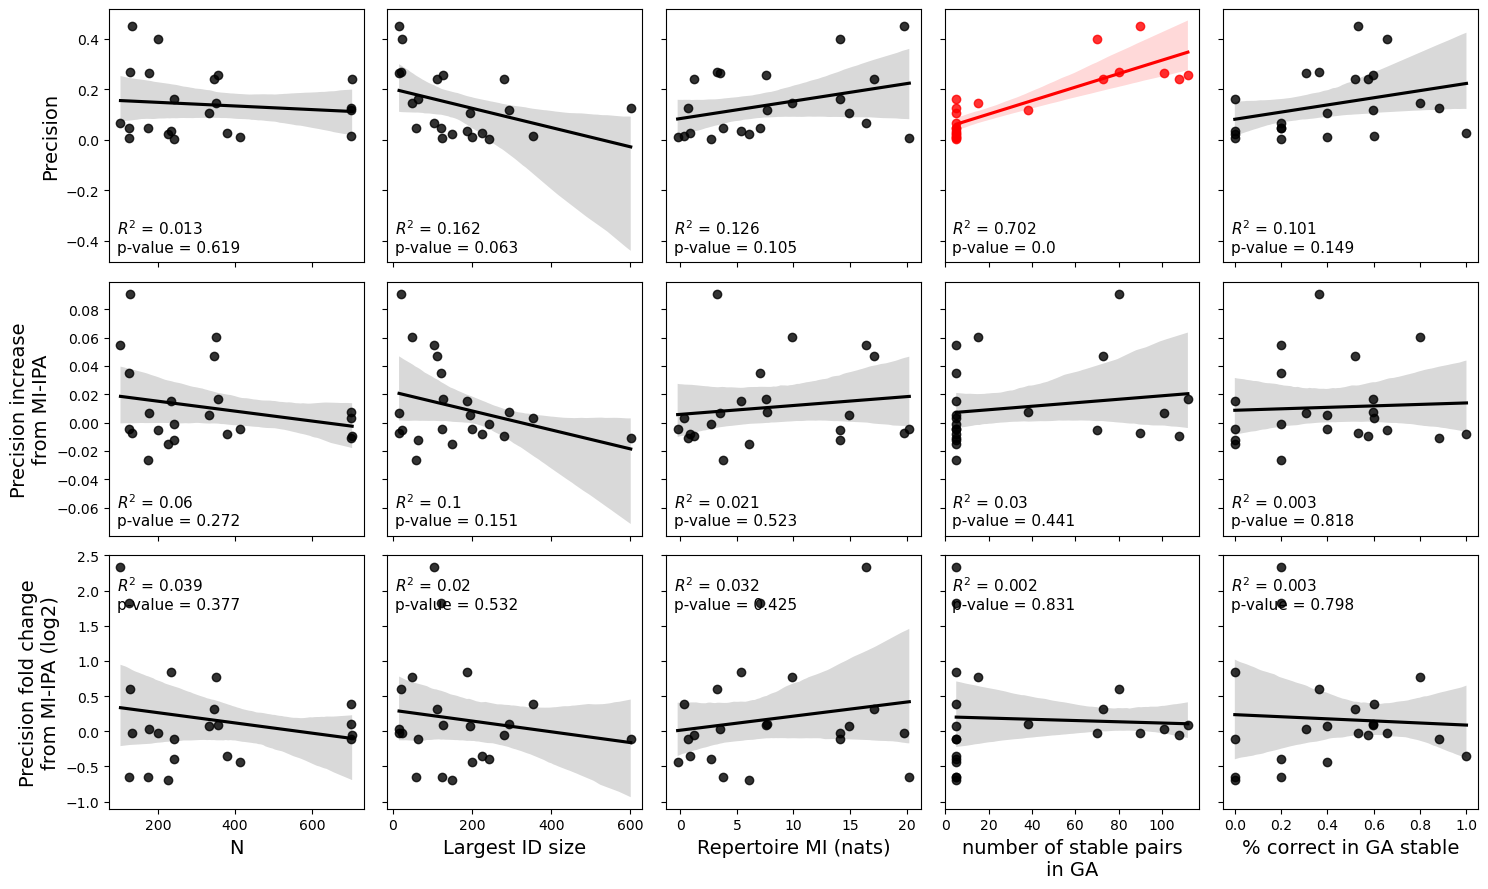

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=5, sharex='col', sharey='row', figsize=(15,9))
titles = {'N':'N',
          'largest_id':'Largest ID size',
          'real_MI':'Repertoire MI (nats)',
          'GA_training_size':'number of stable pairs\nin GA',
          'GA_prop_correct':'% correct in GA stable'}
models = ['No-learning', 'Learning','Theoretical best']


for w,c in enumerate(['N', 'largest_id', 'real_MI','GA_training_size','GA_prop_correct']):
    print(models, c)
    print(X.shape)
    assert X.shape[0] == len(epitopes)
    X['GA_increase'] = X['GA_increase'].replace(np.inf, np.nan)
    p,R,Rsq_adj = simple_regplot(X,[c],'prop_correct')
    p1,R1,R1sq_adj = simple_regplot(X,[c],'GA_increase1')
    p2,R2,R2sq_adj = simple_regplot(X,[c],'GA_increase')
    # ax[w].set_title(titles[c], fontdict={'size':14})
    
    # ax[0, w].set_title(r'$R^2$ = ' + str(R.round(3)) + ', p-value = ' + str(p.round(3)), loc='left')
    # ax[1, w].set_title(r'$R^2$ = ' + str(R1.round(3)) + ', p-value = ' + str(p1.round(3)), loc='left')
    ax[0,w].text(0.03,0.03,r'$R^2$ = ' + str(R.round(3)) + '\np-value = ' + str(p.round(3)), 
                        transform=ax[0,w].transAxes, verticalalignment='bottom', horizontalalignment='left',
                        fontdict={'size':11})
    ax[1,w].text(0.03,0.03,r'$R^2$ = ' + str(R1.round(3)) + '\np-value = ' + str(p1.round(3)), 
                        transform=ax[1,w].transAxes, verticalalignment='bottom', horizontalalignment='left',
                        fontdict={'size':11})
    ax[2,w].text(0.03,0.92,r'$R^2$ = ' + str(R2.round(3)) + '\np-value = ' + str(p2.round(3)), 
                        transform=ax[2,w].transAxes, verticalalignment='top', horizontalalignment='left',
                        fontdict={'size':11})
    # ax[0,w].text(0.03,0.03,r'$R^2$ = ' + str(R.round(3)) + ', p-value = ' + str(p.round(3)), 
    #                 transform=ax[0,w].transAxes, verticalalignment='bottom', horizontalalignment='left',
    #                 fontdict={'size':11})
    # ax[1,w].text(0.03,0.03,r'$R^2$ = ' + str(R1.round(3)) + ', p-value = ' + str(p1.round(3)), 
    #                 transform=ax[1,w].transAxes, verticalalignment='bottom', horizontalalignment='left',
    #                 fontdict={'size':11})
    col1= 'k'
    col2= 'k'
    col3= 'k'
    if p < 0.05:
        col1='red'
    if p1 < 0.05:
        col2='red'
    if p2 < 0.05:
        col3='red'
    sns.regplot(data=X, x = c, y = 'prop_correct', ax=ax[0,w], color=col1, x_ci='ci', ci=95)
    sns.regplot(data=X, x = c, y = 'GA_increase1', ax=ax[1,w], color=col2, x_ci='ci', ci=95)
    sns.regplot(data=X, x = c, y = 'GA_increase', ax=ax[2,w], color=col3, x_ci='ci', ci=95)

    if w == 0:
        ax[0,w].set_ylabel('Precision', fontsize=14)
        ax[1,w].set_ylabel('Precision increase\nfrom MI-IPA', fontsize=14)
        ax[2,w].set_ylabel('Precision fold change\nfrom MI-IPA (log2)', fontsize=14)
    else:
        ax[0,w].set_ylabel('')
        ax[1,w].set_ylabel('')
        ax[2,w].set_ylabel('')
    ax[0,w].set_xlabel('')
    ax[1,w].set_xlabel('')
    ax[2,w].set_xlabel(titles[c], fontsize=14)

plt.tight_layout()
plt.savefig(save_folder1 + 'GA+MI-IPA_correlations_with_TPR.png',
                bbox_inches="tight")
plt.show()

In [26]:
X['N_norm'] = (X['N'] - X['N'].mean())/X['N'].mean()
X['Na_norm'] = (X['Na'] - X['Na'].mean())/X['Na'].mean()
X['Nb_norm'] = (X['Nb'] - X['Nb'].mean())/X['Nb'].mean()
X['largest_id_norm'] =(X['largest_id'] - X['largest_id'].mean())/X['largest_id'].mean()
X['real_MI_norm'] = (X['real_MI'] - X['real_MI'].mean())/X['real_MI'].mean()
X['stable_GA_norm'] = (X['GA_training_size'] - X['GA_training_size'].mean())/X['GA_training_size'].mean()
X['GA_prop_correct_norm'] = (X['GA_prop_correct'] - X['GA_prop_correct'].mean())/X['GA_prop_correct'].mean()

(array([4., 0., 4., 2., 2., 5., 2., 0., 2., 1.]),
 array([-1.        , -0.75629965, -0.51259931, -0.26889896, -0.02519862,
         0.21850173,  0.46220207,  0.70590242,  0.94960276,  1.19330311,
         1.43700345]),
 <BarContainer object of 10 artists>)

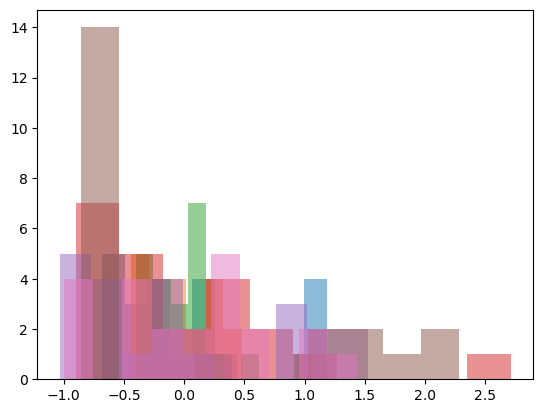

In [27]:
ax=plt.subplot()
ax.hist(X['N_norm'], alpha=0.5)
ax.hist(X['Na_norm'], alpha=0.5)
ax.hist(X['Nb_norm'], alpha=0.5)
ax.hist(X['largest_id_norm'], alpha=0.5)
ax.hist(X['real_MI_norm'], alpha=0.5)
ax.hist(X['stable_GA_norm'], alpha=0.5)
ax.hist(X['GA_prop_correct_norm'], alpha=0.5)

In [28]:
X.head()

,real,shuffle,epitope,var1,var2,real_MI,L,Na,Nb,N,...,correct_to_add,GA_training_size,GA_prop_correct,N_norm,Na_norm,Nb_norm,largest_id_norm,real_MI_norm,stable_GA_norm,GA_prop_correct_norm
0,42.514086,28.393550,ASNENMETM,CDR3a,CDR3b,14.120535,0.6,1.571904,1.464015,201.0,...,46.0,70.0,0.657143,-0.376481,-0.412261,-0.380742,-0.857969,0.762099,1.047872,0.601459
1,62.903822,42.657593,ATDALMTGF,CDR3a,CDR3b,20.246229,0.6,3.898914,1.875651,125.0,...,0.0,5.0,0.000000,-0.612239,0.457814,-0.206626,-0.228092,1.526523,-0.853723,-1.000000
2,30.203834,29.848713,AVFDRKSDAK,CDR3a,CDR3b,0.355122,0.6,3.186300,2.482818,700.0,...,3.0,5.0,0.600000,1.171461,0.191366,0.050197,1.179869,-0.955684,-0.853723,0.462202
3,56.597613,50.543606,CINGVCWTV,CDR3a,CDR3b,6.054008,0.6,3.138194,2.634058,226.0,...,0.0,5.0,0.000000,-0.298928,0.173379,0.114169,-0.073710,-0.244522,-0.853723,-1.000000
4,35.442074,34.560753,ELAGIGILTV,CDR3a,CDR3b,0.881321,0.6,2.715217,1.865787,380.0,...,5.0,5.0,1.000000,0.178793,0.015227,-0.210798,0.389435,-0.890020,-0.853723,1.437003


In [29]:
factors = ['N_norm','largest_id_norm','real_MI_norm','stable_GA_norm','GA_prop_correct_norm']#'Na_norm','Nb_norm',
factors1 = ['largest_id_norm','stable_GA_norm','GA_prop_correct_norm']#'Na_norm','Nb_norm',

In [30]:
# learning model
pval,Rsq,Rsq_adj = simple_regplot(X, x=factors, y='prop_correct')

['N_norm', 'largest_id_norm', 'real_MI_norm', 'stable_GA_norm', 'GA_prop_correct_norm'] prop_correct
prop_correct ~ N_norm + largest_id_norm + real_MI_norm + stable_GA_norm + GA_prop_correct_norm
                            OLS Regression Results                            
Dep. Variable:           prop_correct   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     15.91
Date:                Tue, 21 May 2024   Prob (F-statistic):           1.03e-05
Time:                        03:01:52   Log-Likelihood:                 33.685
No. Observations:                  22   AIC:                            -55.37
Df Residuals:                      16   BIC:                            -48.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
              

In [31]:
pval,Rsq,Rsq_adj = simple_regplot(X, x=factors1, y='prop_correct')

['largest_id_norm', 'stable_GA_norm', 'GA_prop_correct_norm'] prop_correct
prop_correct ~ largest_id_norm + stable_GA_norm + GA_prop_correct_norm
                            OLS Regression Results                            
Dep. Variable:           prop_correct   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     19.09
Date:                Tue, 21 May 2024   Prob (F-statistic):           7.97e-06
Time:                        03:01:52   Log-Likelihood:                 29.769
No. Observations:                  22   AIC:                            -51.54
Df Residuals:                      18   BIC:                            -47.17
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|

In [32]:
pval,Rsq,Rsq_adj = simple_regplot(X, x=factors, y='GA_increase')

['N_norm', 'largest_id_norm', 'real_MI_norm', 'stable_GA_norm', 'GA_prop_correct_norm'] GA_increase
GA_increase ~ N_norm + largest_id_norm + real_MI_norm + stable_GA_norm + GA_prop_correct_norm
                            OLS Regression Results                            
Dep. Variable:            GA_increase   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.234
Method:                 Least Squares   F-statistic:                    0.2027
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.957
Time:                        03:01:52   Log-Likelihood:                -23.720
No. Observations:                  22   AIC:                             59.44
Df Residuals:                      16   BIC:                             65.99
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                

In [33]:
pval,Rsq,Rsq_adj = simple_regplot(X, x=factors, y='GA_increase1')

['N_norm', 'largest_id_norm', 'real_MI_norm', 'stable_GA_norm', 'GA_prop_correct_norm'] GA_increase1
GA_increase1 ~ N_norm + largest_id_norm + real_MI_norm + stable_GA_norm + GA_prop_correct_norm
                            OLS Regression Results                            
Dep. Variable:           GA_increase1   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                    0.5336
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.748
Time:                        03:01:52   Log-Likelihood:                 48.735
No. Observations:                  22   AIC:                            -85.47
Df Residuals:                      16   BIC:                            -78.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
              

In [34]:
pval,Rsq,Rsq_adj = simple_regplot(X, x=factors1, y='GA_increase')

['largest_id_norm', 'stable_GA_norm', 'GA_prop_correct_norm'] GA_increase
GA_increase ~ largest_id_norm + stable_GA_norm + GA_prop_correct_norm
                            OLS Regression Results                            
Dep. Variable:            GA_increase   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.131
Method:                 Least Squares   F-statistic:                    0.1919
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.901
Time:                        03:01:52   Log-Likelihood:                -24.050
No. Observations:                  22   AIC:                             56.10
Df Residuals:                      18   BIC:                             60.46
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|  

In [35]:
pval,Rsq,Rsq_adj = simple_regplot(X, x=['stable_GA_norm','GA_prop_correct_norm'], y='GA_increase')

['stable_GA_norm', 'GA_prop_correct_norm'] GA_increase
GA_increase ~ stable_GA_norm + GA_prop_correct_norm
                            OLS Regression Results                            
Dep. Variable:            GA_increase   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.100
Method:                 Least Squares   F-statistic:                   0.04310
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.958
Time:                        03:01:53   Log-Likelihood:                -24.346
No. Observations:                  22   AIC:                             54.69
Df Residuals:                      19   BIC:                             57.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------